In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# from tqdm import tqdn_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/ytrue)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import yfinance as yf
# Set the start and end date
start_date = '2021-05-19'
end_date = '2023-05-19'
# Set the ticker
ticker = 'BNTX'
# Get the data
data = yf.download(ticker, start_date, end_date)
# Print the last 5 rows
print(data.head(10))

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2021-05-19  190.000000  199.240005  186.720001  199.080002  196.477631  \
2021-05-20  199.169998  209.020004  198.300003  203.710007  201.047104   
2021-05-21  204.130005  205.190002  195.429993  195.690002  193.131943   
2021-05-24  197.509995  199.988007  193.279999  194.889999  192.342392   
2021-05-25  194.460007  200.139999  193.699997  197.500000  194.918274   
2021-05-26  197.600006  203.500000  197.507004  202.369995  199.724609   
2021-05-27  199.050003  203.494995  196.179993  197.699997  195.115662   
2021-05-28  199.110001  208.600006  199.100006  204.000000  201.333313   
2021-06-01  204.570007  209.800003  204.479996  206.139999  203.445328   
2021-06-02  206.259995  219.940002  205.199997  219.399994  216.531998   

             Volume  
Date                

In [2]:
drop_cols = ['Adj Close','Volume']
data.drop(drop_cols, axis=1, inplace=True)
data.head()
#seasonality - periodic fluctuations
#stationary - statistical properties do not change over time

,Open,High,Low,Close
Date,,,,
2021-05-19,190.000000,199.240005,186.720001,199.080002
2021-05-20,199.169998,209.020004,198.300003,203.710007
2021-05-21,204.130005,205.190002,195.429993,195.690002
2021-05-24,197.509995,199.988007,193.279999,194.889999
2021-05-25,194.460007,200.139999,193.699997,197.500000


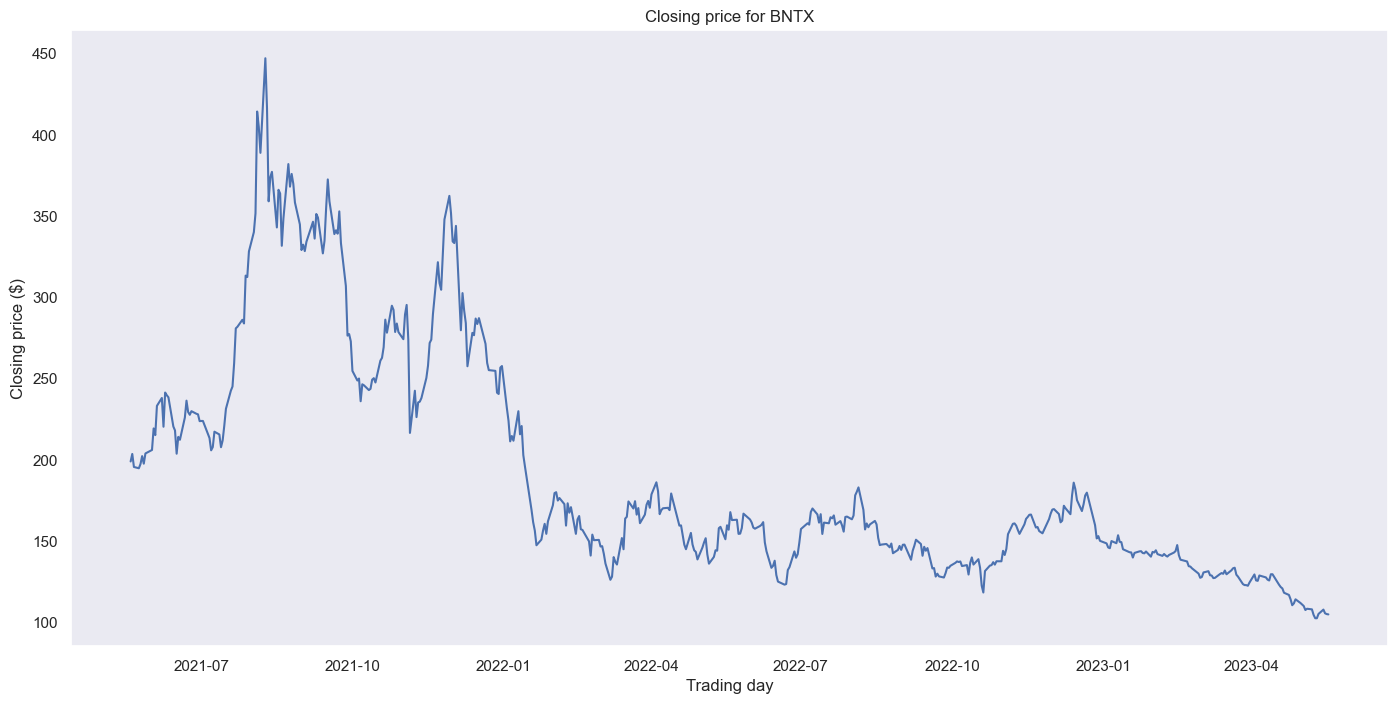

In [3]:
# exploratory Data Analysis (EDA)
plt.figure(figsize=(17,8))
plt.plot(data.Close)
plt.title('Closing price for {}'.format(ticker))
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

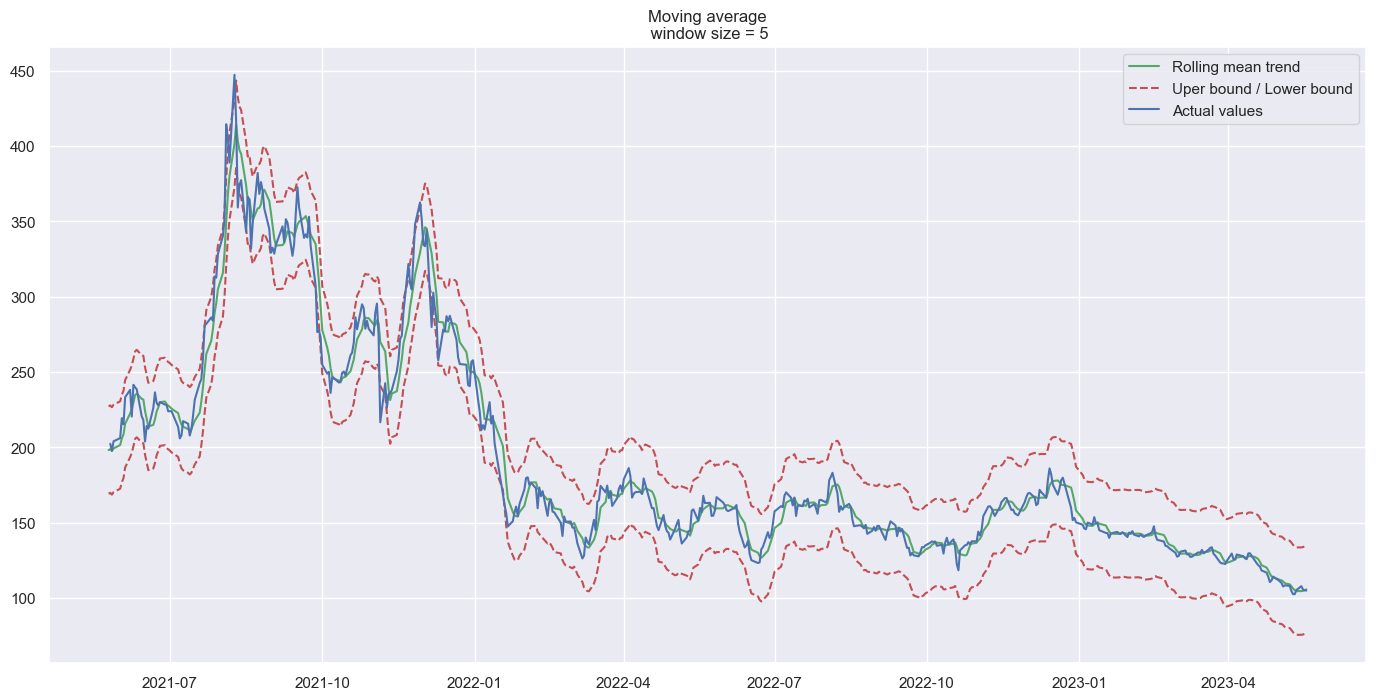

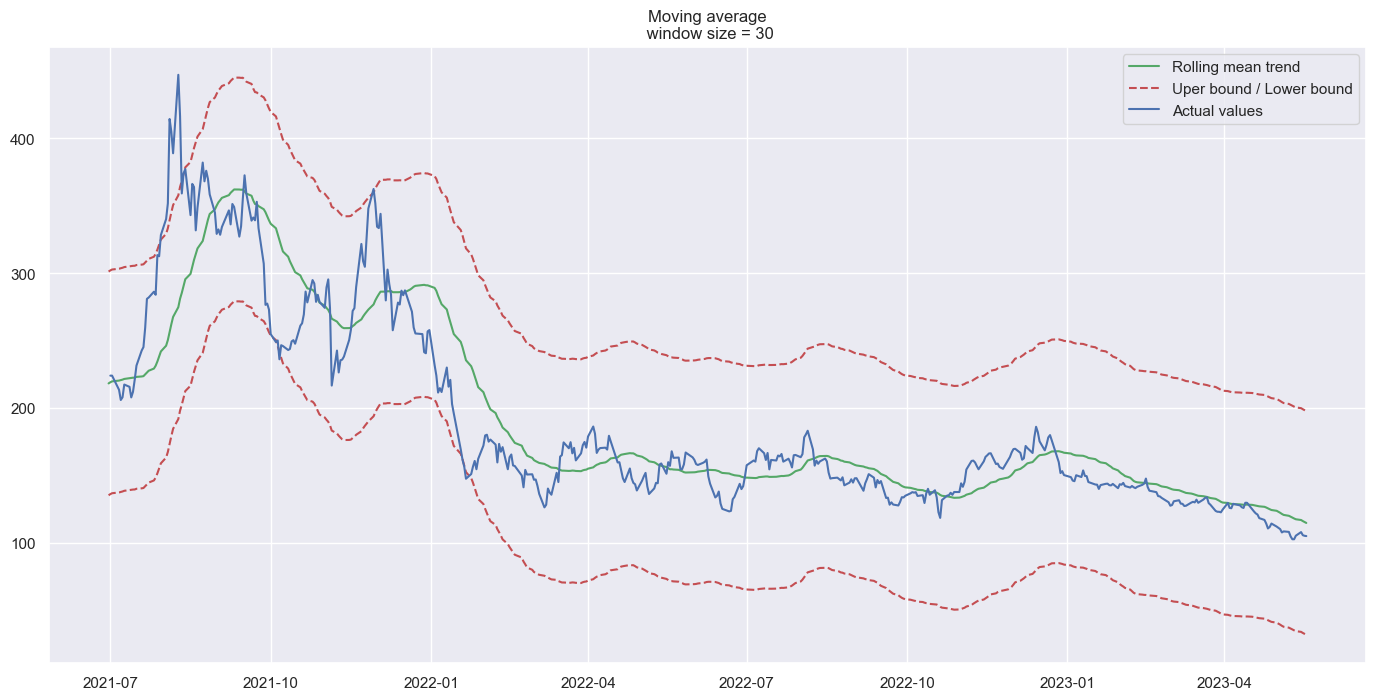

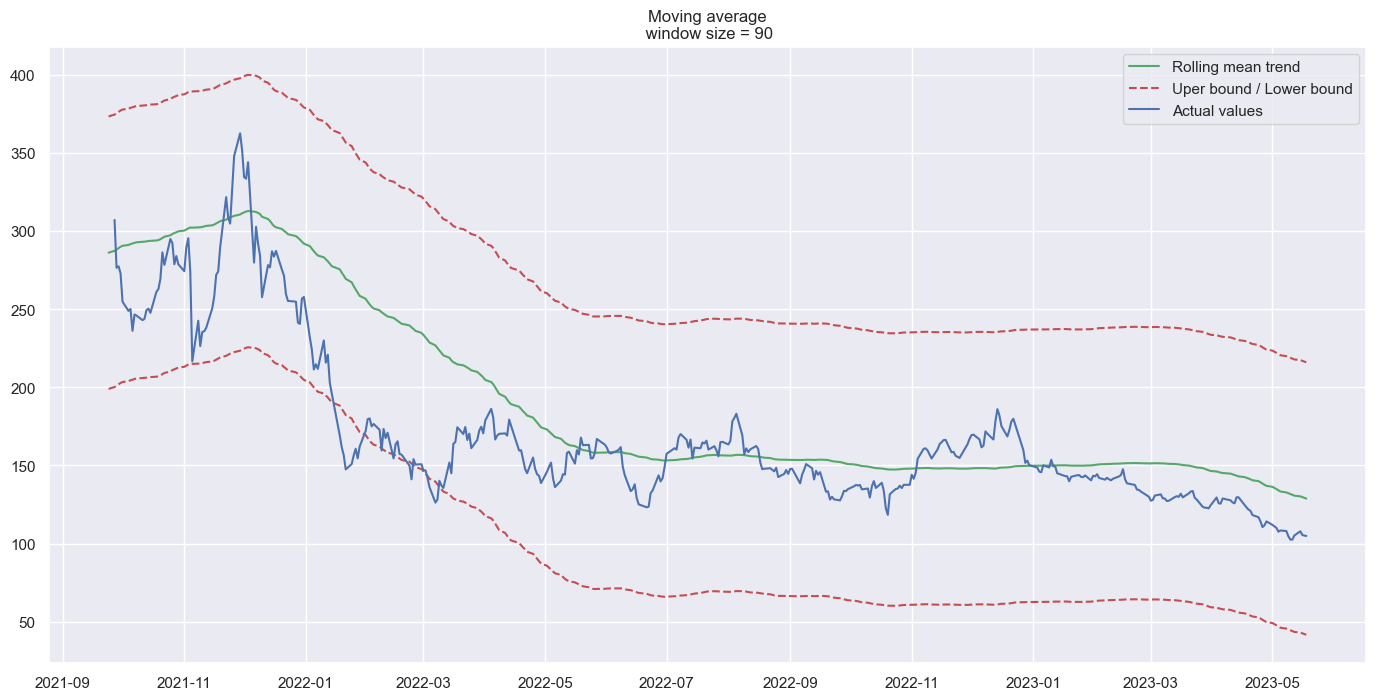

In [4]:
#moving average

def plot_moving_average(series, window,plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean,'g', label='Rolling mean trend')

    #plot confidence intervals forsmooth values
    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound,'r--',label='Uper bound / Lower bound')
        plt.plot(lower_bound,'r--')
    plt.plot(series[window:],label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
#smooth by previous 5 days
plot_moving_average(data.Close,5,plot_intervals=True)
#smooth by previous 30 days
plot_moving_average(data.Close,30,plot_intervals=True)
#smooth by previous 90 days
plot_moving_average(data.Close,90,plot_intervals=True)

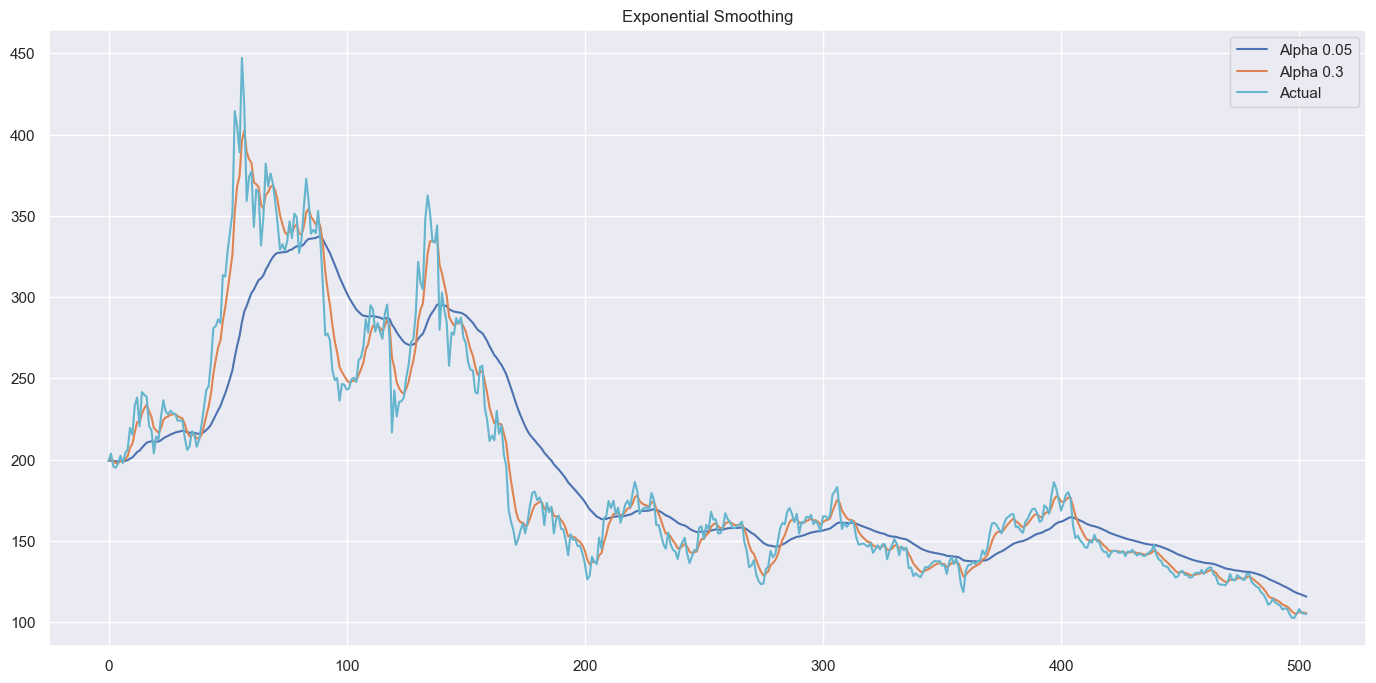

In [5]:
# exponencial smoothing
def exponential_smoothing(series,alpha):
    result = [series[0]] # firstvalue of series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1-alpha)*result[n-1])
    return result
def plot_exponential_smoothing(series,alphas):
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series,alpha),label="Alpha {}".format(alpha))
    plt.plot(series.values,"c",label="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
plot_exponential_smoothing(data.Close,[0.05,0.3])

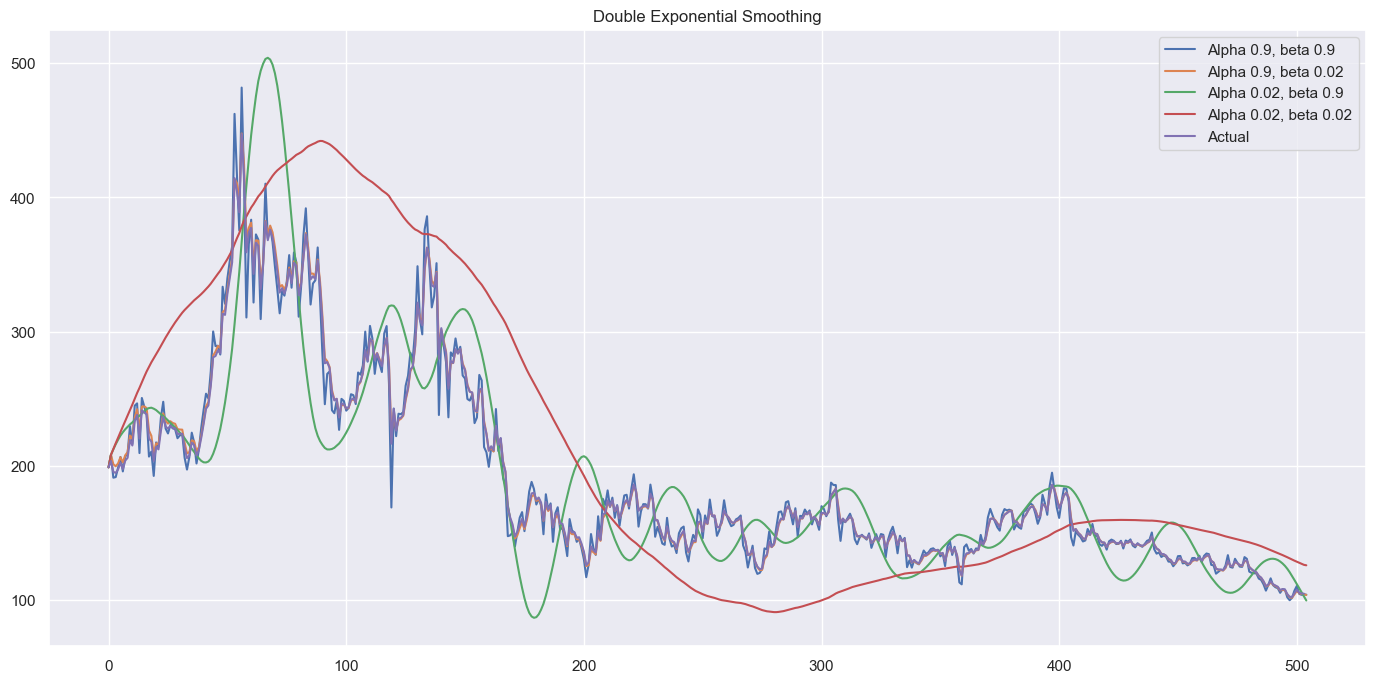

In [6]:
#double exponential smoothing
def double_exponential_smoothing(series,alpha, beta):
    result = [series[0]]
    for n in range(1,len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1] 
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1-alpha) * (level+trend)
        trend = beta * (level - last_level) + (1-beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series,alpha, beta),label="Alpha {}, beta {}".format(alpha,beta))
    plt.plot(series.values,label="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])
            

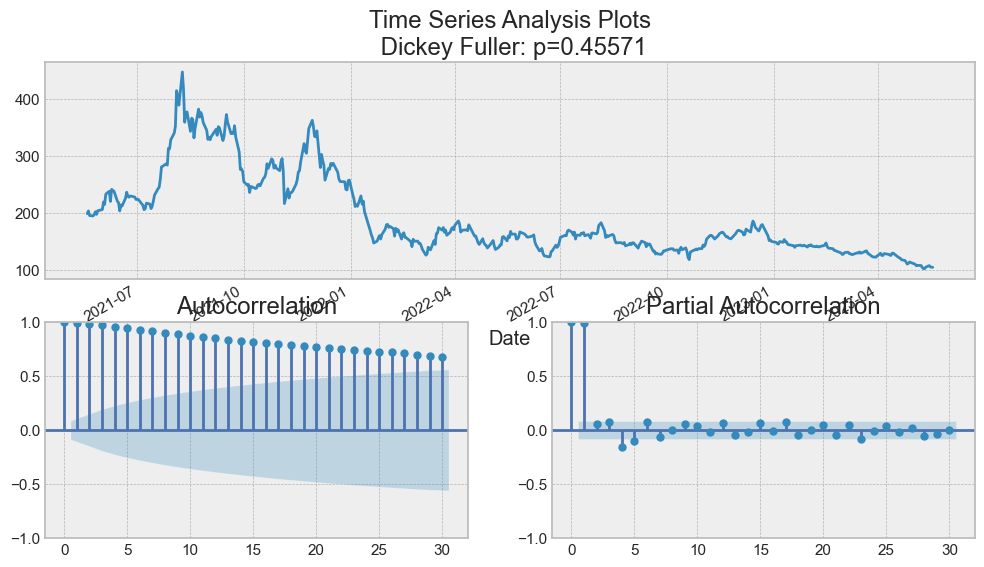

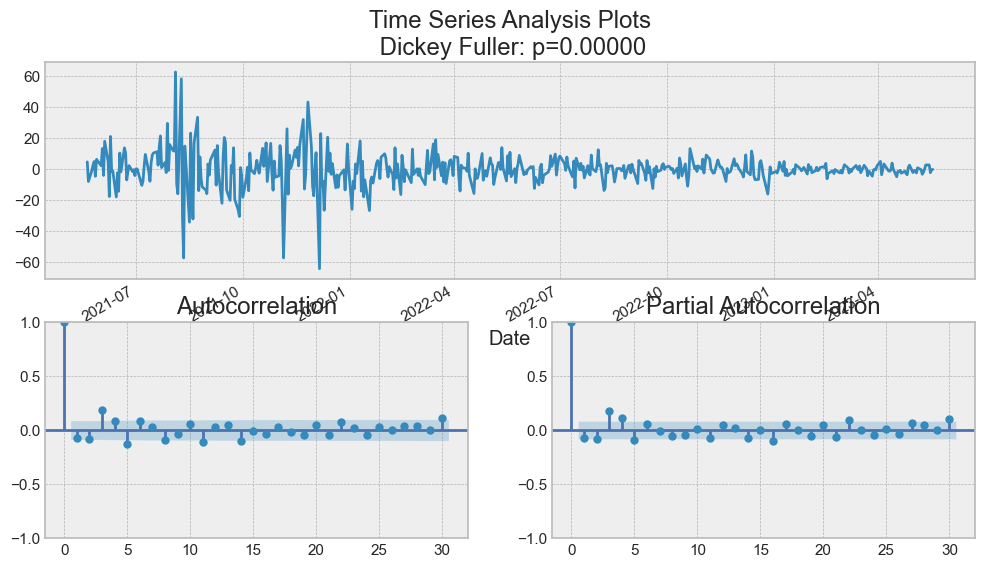

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags= lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags= lags, ax=pacf_ax)
        plt.tight_layout
        
tsplot(data.Close, lags=30)

data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [8]:
#sarima
#set initial values and some bounds
ps = range(0,5)
d = 1
qs = range(0,5)
Ps = range(0,5)
D = 1
Qs = range(0,5)
s=5

#create list of posible parameters
parameters = product(ps,qs,Ps,Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [9]:
from tqdm import tqdm_notebook
#train many SARIMA models to find best parameters
def optimize_SARIMA(parameters_list,d,D,s):
    """
    Return datframe with parameters corresponding to AIC

    parameters list - list with (p,q,P, Q)tuples
    d - integration order
    D - seasonal integration order
    s - length of season
    """
    results= []
    best_aic=float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0],d,param[1]), seasonal_order=(param[2],D,param[3],s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        #save best model
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param,model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns=['parameters','aic']
    #sort in ascending order, lower aic is better
    result_table = result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#set parameters that give the lowest AIC(Akaike Information Criteria)
p,q,P,Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())


  0%|          | 0/625 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  504
Model:             SARIMAX(4, 1, 4)x(1, 1, [1], 5)   Log Likelihood               -1871.043
Date:                             Mon, 22 May 2023   AIC                           3764.086
Time:                                     12:56:54   BIC                           3810.403
Sample:                                          0   HQIC                          3782.264
                                             - 504                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3715      0.073     -5.081      0.000      -0.515      -0.228
ar.L2          0.4961      

In [27]:
model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)

#one step forecast
yhat = model.predict(start=(len(data.Close)-5), end=len(data.Close) )
yhat

499    100.654770
500    104.370533
501    108.856806
502    105.222667
503    107.376097
504    103.080602
Name: predicted_mean, dtype: float64

In [44]:
predicted = list(yhat)
print(predicted)
len(predicted)

[100.65476997144265, 104.37053251596139, 108.85680649775405, 105.22266713871107, 107.376096863615, 103.08060172056427]


6

In [45]:
actual = list(data.Close.tail(6))
print(actual)
len(actual)

[102.58000183105469, 105.23999786376953, 107.9000015258789, 105.5999984741211, 105.1500015258789, 104.94999694824219]


6

In [46]:
index = data.tail(6).index
print(index)
len(index)

DatetimeIndex(['2023-05-11', '2023-05-12', '2023-05-15', '2023-05-16',
               '2023-05-17', '2023-05-18'],
              dtype='datetime64[ns]', name='Date', freq=None)


6

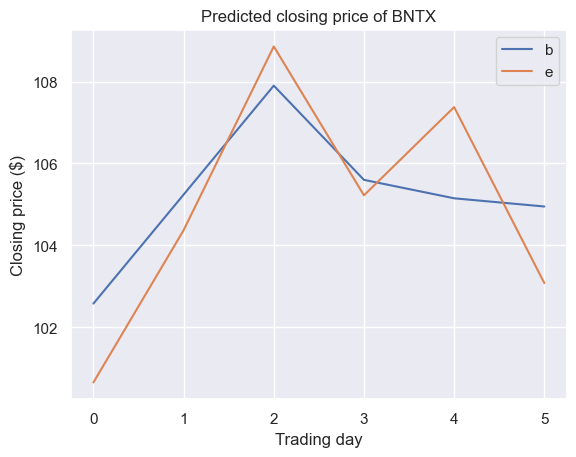

In [69]:
test = list(zip(index,actual,predicted))
test
comparison = pd.DataFrame(test,columns=['index','actual','predicted'])
comparison
fig, ax = plt.subplots()
# ax.figure(figsize=(17,8))
ax.plot(comparison.actual, label='Actual')
ax.plot(comparison.predicted, label='Predicted')
plt.title('Predicted closing price of {}'.format(ticker))
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend('best')
# plt.grid(False)
plt.show()

,parameters,aic
0,"(4, 4, 1, 1)",3764.086346
1,"(4, 4, 4, 1)",3768.268715
2,"(4, 1, 0, 1)",3772.552151
3,"(4, 2, 0, 1)",3773.190995
4,"(1, 3, 1, 1)",3773.233188


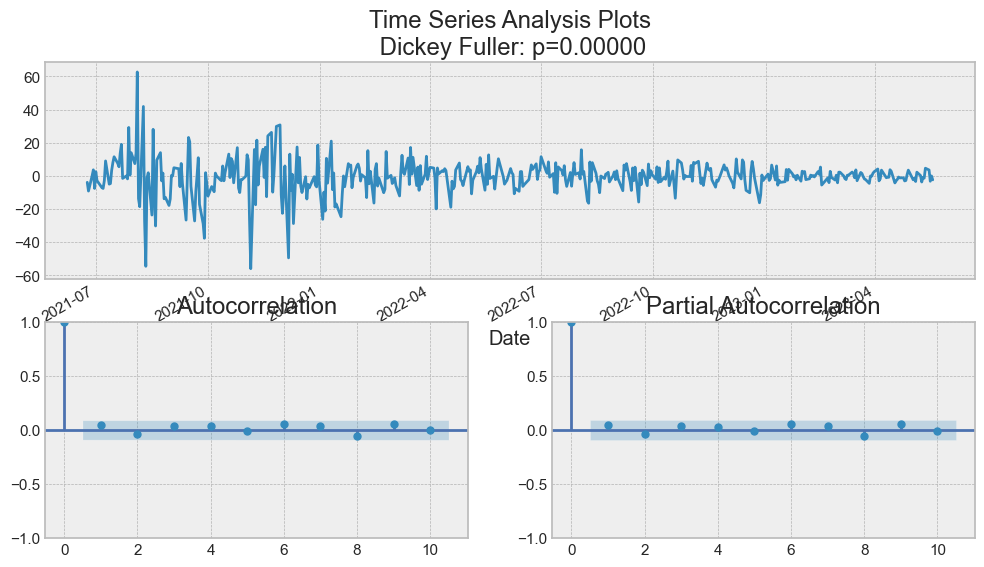

In [11]:
tsplot(best_model.resid[24+1:], lags=10)

In [12]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

In [56]:
df = data['Close']
df = df.reset_index()
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
df


,ds,y
0,2021-05-19,199.080002
1,2021-05-20,203.710007
2,2021-05-21,195.690002
3,2021-05-24,194.889999
4,2021-05-25,197.500000
...,...,...
499,2023-05-12,105.239998
500,2023-05-15,107.900002
501,2023-05-16,105.599998
502,2023-05-17,105.150002


Importing plotly failed. Interactive plots will not work.
15:02:34 - cmdstanpy - INFO - Chain [1] start processing
15:02:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE 15.621051655593552
MAE 18.045652847855287


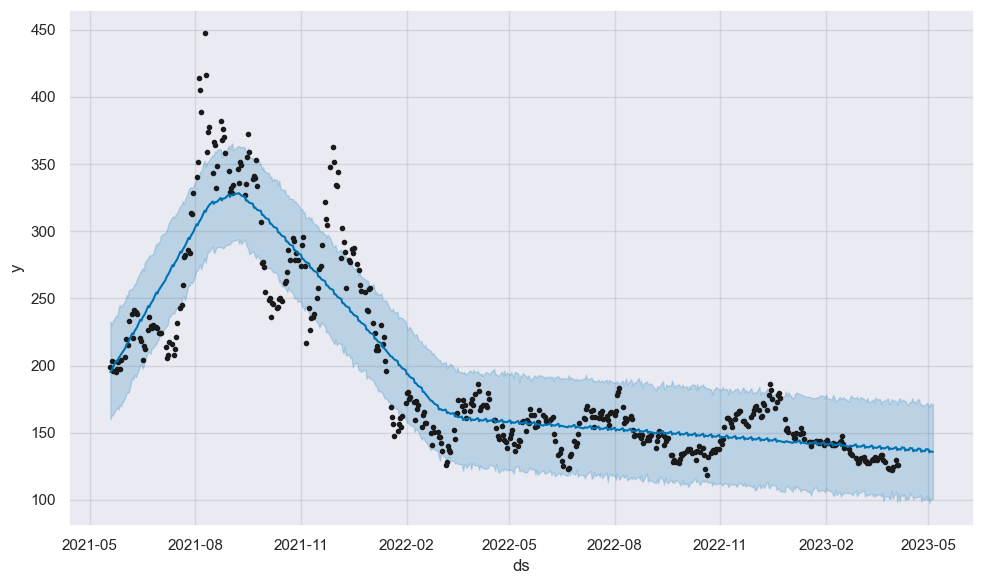

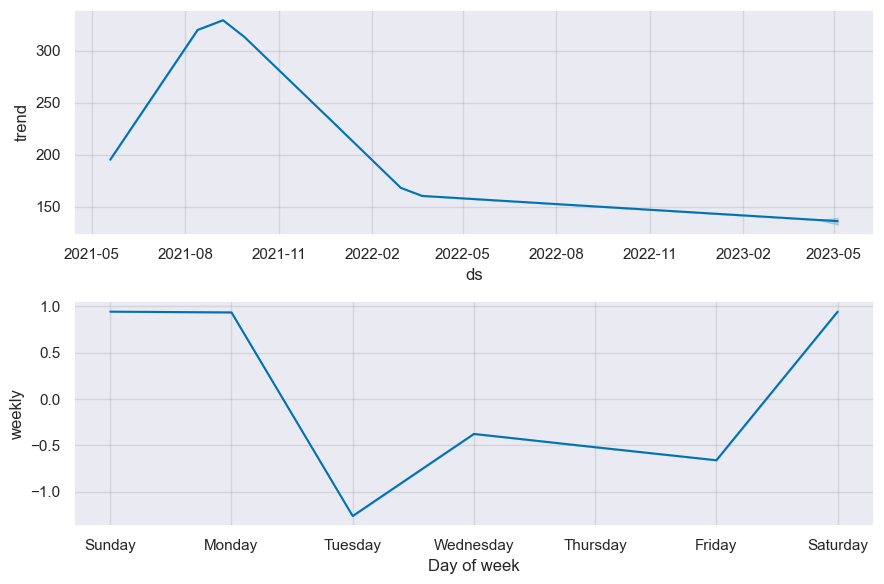

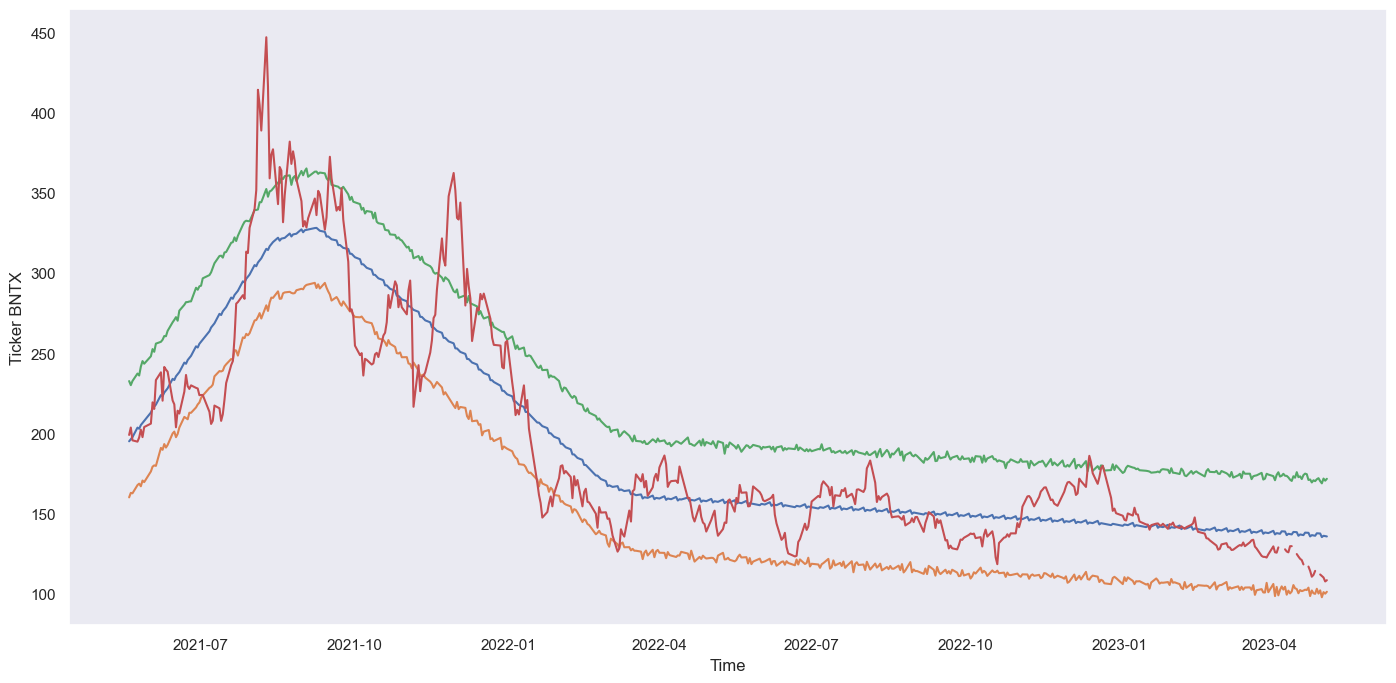

In [57]:
from prophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

#split into a train/test set
prediction_size = 30
train_df = df[:-prediction_size]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#initialize and train
m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
forecast.head()

#plot forecast
m.plot(forecast)

#plot forecasts components
m.plot_components(forecast)

#evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df,forecast)
cmp_df.head()

def calculate_forecast_errors(df, prediction_size):
    df=df.copy()
    df['e']=df['y']-df['yhat']
    df['p']=100*df['e']/df['y']

    predicted_part=df[-prediction_size:]
    error_mean=lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    return {'MAPE':error_mean('p'),'MAE':error_mean('e')}

for err_name,err_value in calculate_forecast_errors(cmp_df,prediction_size).items():
    print(err_name,err_value)

#plot forecast with upper and lower bounds
plt.figure(figsize=(17,8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Ticker {}'.format(ticker))
plt.grid(False)
plt.show()
